In [6]:
# data from https://ourworldindata.org

import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import urllib
import json

# reading data into life expetancy dataframe
life_expectancy = pd.read_csv("life-expectancy.csv")

# deleting unneeded columns
del life_expectancy['Indicator Name']
del life_expectancy['Indicator Code']
del life_expectancy['Country Code']
del life_expectancy['2016']
life_expectancy = life_expectancy.iloc[:, :-1]
life_expectancy.index = life_expectancy['Country Name']
del life_expectancy['Country Name']

# removing countries without entries
life_expectancy = life_expectancy.dropna()

# unstacking the years, turning it into a dataframe from series and resetting indices to prepare for merge
life_expectancy = life_expectancy.stack()
life_expectancy = pd.DataFrame(life_expectancy)
life_expectancy = life_expectancy.reset_index()
life_expectancy = life_expectancy.rename(columns = {'level_1':'Year', 0:'Life Expectancy'})
life_expectancy['Year'] = life_expectancy['Year'].apply(np.int64) # making year values integers

# reading data for spending on healthcare
health_spending = pd.read_csv("hc-exp.csv")

# deleting unneeded columns
del health_spending['Country code']
health_spending = health_spending.rename(columns = {'Entity': 'Country Name'})

# defining years to merge on
years = np.arange(2002, 2014, 1)

# removing elements that are not in the years range
for i in range(len(health_spending.loc[:, 'Year'])):
    if health_spending.loc[i, 'Year'] not in years:
        health_spending.loc[i, 'Year'] = np.nan
        
health_spending = health_spending.dropna()
health_spending['Year'] = health_spending['Year'].apply(np.int64)

for i in range(len(life_expectancy.loc[:, 'Year'])):
    if life_expectancy.loc[i, 'Year'] not in years:
        life_expectancy.loc[i, 'Year'] = np.nan

life_expectancy = life_expectancy.dropna()
life_expectancy['Year'] = life_expectancy['Year'].apply(np.int64)

In [8]:
final_df = pd.merge(health_spending, life_expectancy, on=['Country Name', 'Year'])

In [10]:
# getting information of countries and their regions from the API
geo = urllib.request.urlopen("https://restcountries.eu/rest/v1/all").read()
geo_list = json.loads(geo) 

# filtering only the country name and the subregion
filtered_list =[]
for countries in geo_list:
    filtered_list.append({k:v for (k,v) in countries.items() if k in ['name', 'region','subregion']})

In [42]:
filtered_df = pd.DataFrame(filtered_list)

# merging tables for the subregions and regions
geo_regions = pd.merge(final_df, filtered_df, left_on='Country Name', right_on='name')
del geo_regions['name']

# adding the statistic which needs to be plotted on the y axis
geo_regions['Health Expenditure per Year of Life Expectancy (2002-2014)'] = geo_regions['Health Expenditure']/geo_regions['Life Expectancy']

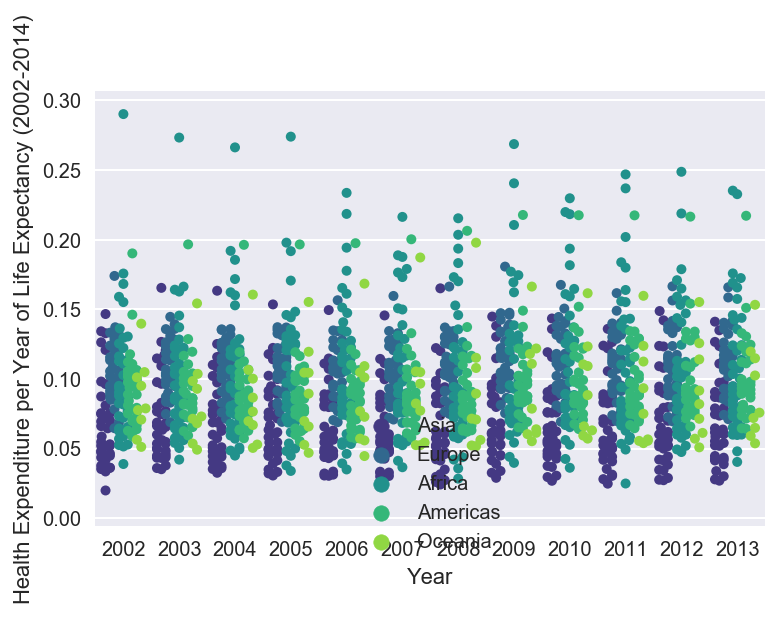

In [68]:
sns.swarmplot(data=geo_regions, x='Year', y='Health Expenditure per Year of Life Expectancy (2002-2014)', palette='viridis', hue='region', split=True)
sns.plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1))